In [25]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime

In [15]:
file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/'

file_list = sorted(glob.glob('/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/2023*.nc'))  # Adjust path based on month


In [16]:
mmdd_list = []
radarAccum_list = []

for file in file_list:
    dayFile = nc.Dataset(file)

    dbz = np.array(dayFile.variables['Zh'][:, 0])
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    a = 18
    b = 1.1

    precip = (z / a) ** (1 / b)

    radarAccum = np.trapz(precip[~np.isnan(precip)], dx=24/len(precip))
    
    # Regular expression to find MMDD after '2023'
    match = re.search(r'/2023(\d{4})', file)
    mmdd = match.group(1)

    mmdd_list.append(mmdd)
    radarAccum_list.append(radarAccum)




/tmp/ipykernel_2432398/2987545486.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  radarAccum = np.trapz(precip[~np.isnan(precip)], dx=24/len(precip))


In [17]:
df = pd.DataFrame({'mmdd': mmdd_list, 'radarAccum': radarAccum_list})
df.to_csv('accumulation_by_day.csv', index=False)

In [ ]:
# [:, 0] is radar
# 1 is disdrometer
# 2, 3 are era5 lower and upper bounds
allAccum = np.empty([365, 4])
allAccum[:, :] = np.nan

In [29]:
radarAccumArr = np.array(radarAccum_list)
mmddArr = np.array(mmdd_list)

for i in range(len(mmddArr)):
    date_obj = datetime.strptime('2023' + mmddArr[i], '%Y%m%d')
    day_of_year_idx = date_obj.timetuple().tm_yday - 1  # 0-based indexing

    allAccum[day_of_year_idx, 0] = radarAccumArr[i]

In [60]:
print(np.sum(radarAccumArr))

788.989


In [47]:
dis_file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/disdrometer/'

dis_file_list = sorted(glob.glob('/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/disdrometer/2023*.nc'))  # Adjust path based on month

dis_mmdd_list = []
disAccum_list = []

for dis_file in dis_file_list:
    dayFile = nc.Dataset(dis_file)

    rainRate = np.array(dayFile.variables['rainfall_rate']) * 1000 * 60 * 60 # time units
    snowRate = (rainRate ** 1.9) * 0.03344 # Matrosov et al (2022) mass size relation

    disdAccum = np.trapz(snowRate, dx=24/len(snowRate))
    
    # Regular expression to find MMDD after '2023'
    match = re.search(r'/2023(\d{4})', dis_file)
    mmdd = match.group(1)

    dis_mmdd_list.append(mmdd)
    disAccum_list.append(disdAccum)




/tmp/ipykernel_2432398/946922384.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rainRate = np.array(dayFile.variables['rainfall_rate']) * 1000 * 60 * 60 # time units
/tmp/ipykernel_2432398/946922384.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  disdAccum = np.trapz(snowRate, dx=24/len(snowRate))


In [48]:
disdf = pd.DataFrame({'mmdd': dis_mmdd_list, 'disAccum': disAccum_list})
disdf.to_csv('disdrometer_accumulation_by_day.csv', index=False)

In [49]:
disAccumArr = np.array(disAccum_list)
dismmddArr = np.array(dis_mmdd_list)

for i in range(len(dismmddArr)):
    date_obj = datetime.strptime('2023' + dismmddArr[i], '%Y%m%d')
    day_of_year_idx = date_obj.timetuple().tm_yday - 1  # 0-based indexing

    allAccum[day_of_year_idx, 1] = disAccumArr[i]

In [52]:
print(np.sum(disAccumArr))

6223.8438


Text(0.5, 1.0, 'Radar vs Disdrometer, Disdrometer y limits')

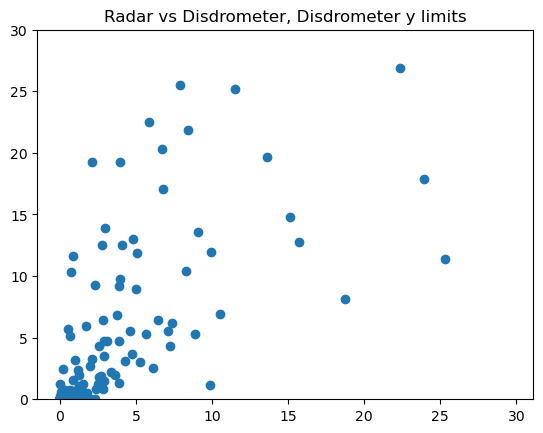

In [56]:
plt.scatter(allAccum[:, 0], allAccum[:, 1])
plt.ylim(0, 30)
plt.title("Radar vs Disdrometer, Disdrometer y limits")

Text(0.5, 1.0, 'Radar vs Disdrometer, no limits')

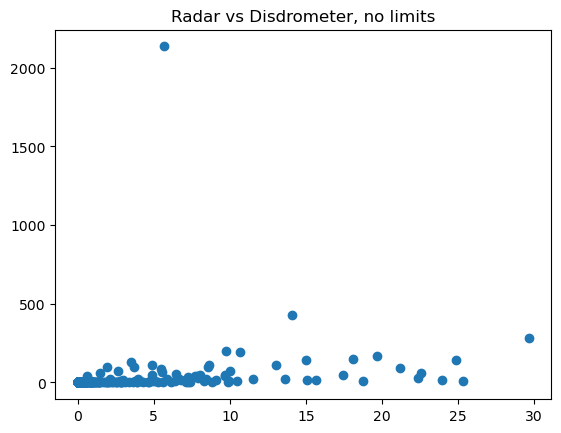

In [57]:
plt.scatter(allAccum[:, 0], allAccum[:, 1])
plt.title("Radar vs Disdrometer, no limits")

In [58]:
#file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/20230426_neumayer_mira.nc'
modfile_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/era_precip/a5fe22a8557d37e66a32d5412c5f2411.nc'
model = nc.Dataset(modfile_path)

# Coords of Neumayer III
minMod = np.array(model.variables['mntpr'][:, 23, 87]) * 60 * 60
maxMod = np.array(model.variables['mxtpr'][:, 23, 87]) * 60 * 60

print(model)

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2025-06-09T10:33 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.41.0 with {"source": "tmp7xxvkl77/data.grib", "filter_by_keys": {"stream": ["oper"], "stepType": ["max"]}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(8760), latitude(41), longitude(241)
    variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 mxtpr(valid_time, latitude, longitude), float32 mntpr(valid_time, latitude, longitude)
    groups: 


In [59]:
eraUpperAccum = np.trapz(maxMod)
eraLowerAccum = np.trapz(minMod)

print(eraUpperAccum)
print(eraLowerAccum)

836.20294
711.5617


/tmp/ipykernel_2432398/549868540.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraUpperAccum = np.trapz(maxMod)
/tmp/ipykernel_2432398/549868540.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  eraLowerAccum = np.trapz(minMod)


In [ ]:
accum_daily_low = np.sum(minMod.reshape(365, 24), axis=1)
accum_daily_high = np.sum(maxMod.reshape(365, 24), axis=1)


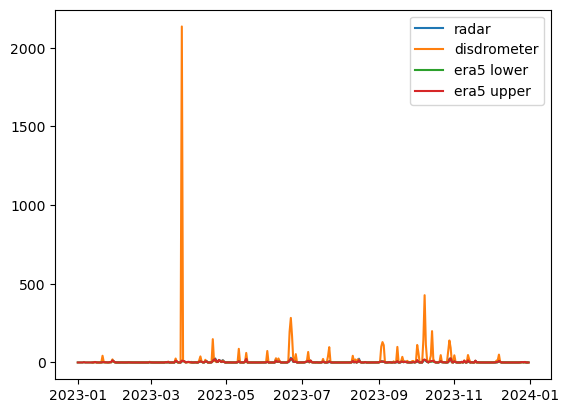

In [65]:
dates = np.arange('2023-01-01', '2024-01-01', dtype='datetime64[D]')
plt.plot(dates, allAccum[:, 0], label='radar')
plt.plot(dates, allAccum[:, 1], label='disdrometer')
plt.plot(dates, accum_daily_low, label='era5 lower')
plt.plot(dates, accum_daily_high, label='era5 upper')

plt.legend()


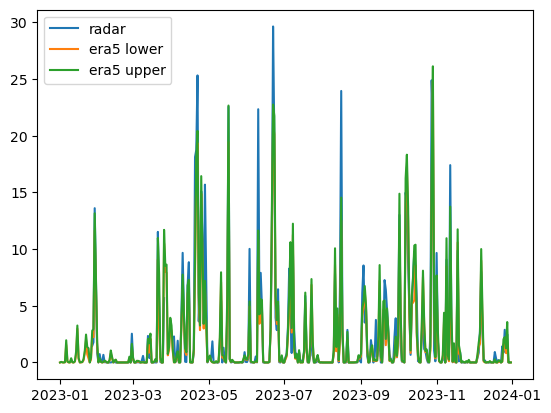

In [66]:
dates = np.arange('2023-01-01', '2024-01-01', dtype='datetime64[D]')
plt.plot(dates, allAccum[:, 0], label='radar')
#plt.plot(dates, allAccum[:, 1], label='disdrometer')
plt.plot(dates, accum_daily_low, label='era5 lower')
plt.plot(dates, accum_daily_high, label='era5 upper')

plt.legend()


Text(0.5, 1.0, 'Radar vs ERA5')

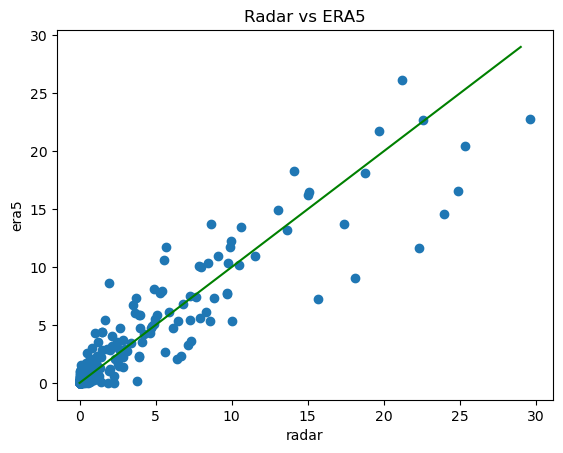

In [83]:
plt.scatter(allAccum[:, 0], accum_daily_high)
plt.ylabel('era5')
plt.xlabel('radar')
plt.plot(np.arange(0, 30), np.arange(0, 30), c='green')
plt.title("Radar vs ERA5")

In [76]:
datesPD = pd.date_range('2023-01-01', periods=365, freq='D')

mmdd_new = datesPD.strftime('%m%d')

# Build the DataFrame
df = pd.DataFrame({
    'mmdd': mmdd_new,
    'accum': accum_daily_low
})


# Save to CSV
df.to_csv('era5_accumulation_low.csv', index=False)

In [82]:
print("Radar Accumulation: " + str(np.sum(radarAccumArr)) + " mm")
print("Disdrometer Accumulation: " + str(np.sum(disAccumArr)) + " mm")
print("ERA5 Accumulation Lower: " + str(eraLowerAccum) + " mm")
print("ERA5 Accumulation Upper: " + str(eraUpperAccum) + " mm")

Radar Accumulation: 788.989 mm
Disdrometer Accumulation: 6223.8438 mm
ERA5 Accumulation Lower: 711.5617 mm
ERA5 Accumulation Upper: 836.20294 mm
